# Contact with the Lagrange Multiplier Method


In [1]:
import cmcrameri.cm as cmc
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import Array

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.utils import auto_vmap, vmap
from femsolver import Mesh, Operator, element

In [2]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


mesh = Mesh.unit_square(10, 10)
tri = element.Tri3()
op = Operator(mesh, tri)
material = Material(mu=1.0, lmbda=1.0)


n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

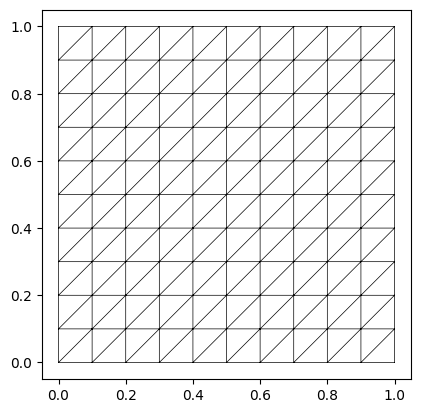

In [3]:
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")

## Constitutive Model for Linear Elasticity

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x)
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$

The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$


The femsolver provides a generic class `Operator` that can be used to solve FEM problems. This operator is the core of the library as it provide functions that can automatically integrate the energy density function defined above over the range of elements.


In [4]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)


@auto_vmap(eps=2)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@auto_vmap(grad_u=2)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, mat: Material) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

### Lagrange Multiplier Method for Contact

The total potential energy $\Psi$ is the sum of the elastic strain energy $\Psi_{elastic}$ and the contact penalty energy $\Psi_{contact}$.

Following a Lagrange multiplier approach, we define the total Lagrangian as:

$$
\mathcal{L}(u, \lambda) = \Psi_{elastic}(u) + \int_{\Gamma_c} \lambda g(u) dA
$$

Subject to the Kuhn-Tucker conditions

$$
g(u) \leq 0, \quad \lambda \geq 0, \quad \lambda g(u) = 0 \quad \text{on } \Gamma_c
$$


### Discrete Formulation

Assign one multiplier per contact node (x dof for each node):

$$
\mathcal{L}(u, \lambda) = \Psi_{elastic}(u) + \sum_{i=1}^{N_c} \lambda_i g_i(u_i) A_i
$$


In [15]:
from femsolver.solver import newton_solver
import numpy as np


class State(NamedTuple):
    """State of the system, including displacement and Lagrange multipliers."""

    u: Array  # Displacement field
    lmbda: Array  # Lagrange multipliers for contact nodes


contact_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate([2 * right_nodes, 2 * right_nodes + 1])
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs + contact_nodes.size), fixed_dofs)
right_disp = jnp.array([-0.3, 0.0])


def total_lagrangian(
    u_flat: Array,
    lmbda_flat: Array,
    coords: Array,
    contact_nodes: Array,
) -> Array:
    """Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field (shape: (n_dofs,)).
        lmbda_flat: Flattened Lagrange multipliers (shape: (n_contact,)).
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Total energy.
    """
    constraint = jnp.sum(
        lmbda_flat[: contact_nodes.size]
        * (u_flat[contact_nodes * 2] + coords[contact_nodes, 0] - 0.0)
    ) + jnp.sum(
        lmbda_flat[contact_nodes.size :] * (u_flat[right_nodes * 2] - right_disp[0])
    )

    strain_energy = total_strain_energy(u_flat.reshape(-1, n_dofs_per_node), material)
    return constraint + strain_energy


dU_du = jax.grad(total_lagrangian, argnums=0)
dU_dlmbda = jax.grad(total_lagrangian, argnums=1)
dU_du_du = jax.hessian(total_lagrangian, argnums=0)
dU_du_dlmbda = jax.jacfwd(dU_du, argnums=1)


def residual(state: State) -> Array:
    """Compute the residual of the system.

    Residual is a flat array where the lagrange multipliers are appended to the end of the
    displacement vector.
    """
    u_flat = state.u.flatten()
    lmbda_flat = state.lmbda.flatten()

    res_u = dU_du(u_flat, lmbda_flat, mesh.coords, contact_nodes)
    res_lmbda = dU_dlmbda(u_flat, lmbda_flat, mesh.coords, contact_nodes)

    return jnp.concatenate([res_u, res_lmbda])


def update(state: State, delta: Array) -> State:
    """Update the state with the computed delta."""
    n_contact_nodes = contact_nodes.size
    n_dofs_per_node = state.u.shape[1]

    # Split the delta into displacement and Lagrange multipliers
    delta_u = delta[:n_dofs]
    delta_lmbda = delta[n_dofs:]

    # Update the displacement field
    new_u = state.u + delta_u.reshape(-1, n_dofs_per_node)

    # Update the Lagrange multipliers
    new_lmbda = state.lmbda + delta_lmbda

    return state._replace(u=new_u, lmbda=new_lmbda)


def linear_solve(state: State, residual: Array) -> Array:
    """Assemble the linear system for the Lagrangian."""
    n_lmbdas = contact_nodes.size + right_nodes.size

    # Compute the gradient of the Lagrangian with respect to u and lmbda
    K = dU_du_du(state.u.flatten(), state.lmbda.flatten(), mesh.coords, contact_nodes)
    A = dU_du_dlmbda(
        state.u.flatten(), state.lmbda.flatten(), mesh.coords, contact_nodes
    )

    # assemble the stiffness matrix
    KKT = jnp.concatenate(
        [
            jnp.concatenate([K, A.T], axis=0),
            jnp.concatenate([A, jnp.zeros((n_lmbdas, n_lmbdas))], axis=0),
        ],
        axis=1,
    )

    return jnp.linalg.solve(KKT, -residual)


## Solve system

We arrange the system such that the unknown vector $u$ is flattened. Once we find the solution, we will reshape it back to the original shape.

1. create the unknown vector $u$ with the shape of the number of nodes times the number of degrees of freedom per node
2. create the system matrix $K$ and the right-hand side vector $f$
3. solve the system $K u = f$ for $u$

::: {.callout-note}
We apply the boundary condition using matrix lifting
:::


In [16]:
state_0 = State(
    u=jnp.zeros((n_nodes, n_dofs_per_node)),
    lmbda=jnp.zeros((contact_nodes.size + right_nodes.size), dtype=float),
)

In [17]:
state_solution, _residual_arr = newton_solver(
    residual, linear_solve, update, state_0, maxiter=30, tol=1e-6, verbose=True
)

iter 0: |res| = 0.9949874371066199 [tol=1e-06]
iter 1: |res| = 2.1771145531193836e-15 [tol=1e-06]


In [19]:
state_solution

State(u=Array([[-6.33752310e-17, -9.66657725e-02],
       [ 1.35077135e-16, -8.66657725e-02],
       [-1.61647223e-17, -7.66657725e-02],
       [ 3.57654470e-17, -6.66657725e-02],
       [-3.57344037e-18, -5.66657725e-02],
       [ 8.57470707e-17, -4.66657725e-02],
       [ 1.01820790e-16, -3.66657725e-02],
       [ 7.94910380e-17, -2.66657725e-02],
       [ 3.92988746e-17, -1.66657725e-02],
       [-2.23288982e-19, -6.66577250e-03],
       [ 4.14239028e-17,  3.33422750e-03],
       [-3.00000000e-02, -9.66657725e-02],
       [-3.00000000e-02, -8.66657725e-02],
       [-3.00000000e-02, -7.66657725e-02],
       [-3.00000000e-02, -6.66657725e-02],
       [-3.00000000e-02, -5.66657725e-02],
       [-3.00000000e-02, -4.66657725e-02],
       [-3.00000000e-02, -3.66657725e-02],
       [-3.00000000e-02, -2.66657725e-02],
       [-3.00000000e-02, -1.66657725e-02],
       [-3.00000000e-02, -6.66577250e-03],
       [-3.00000000e-02,  3.33422750e-03],
       [-6.00000000e-02, -9.66657725e-02],
   

## Postprocessing

Let's plot the von Mises stress and the deformed configuration.


In [20]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


u_solution = state_solution.u
# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, material.mu, material.lmbda)
stress_vm = von_mises_stress(stresses)

In [21]:
from matplotlib.pyplot import xlabel
from femsolver.plotting import STYLE_PATH
from matplotlib.axes import Axes

plt.style.use(STYLE_PATH)


def plot_displacement_and_stress(
    ax: Axes, u: Array, mesh: Mesh, stress: Array, scale=1.0
) -> None:
    coords, elements = mesh.coords, mesh.elements
    displaced = coords + scale * u

    ax.triplot(
        coords[:, 0],
        coords[:, 1],
        elements,
        color="black",
        linewidth=0.5,
    )
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(cb, label="Von Mises Stress")
    ax.set(xlabel="x", ylabel="y", title="Von Mises Stress on Deformed Mesh")
    ax.axis("equal")


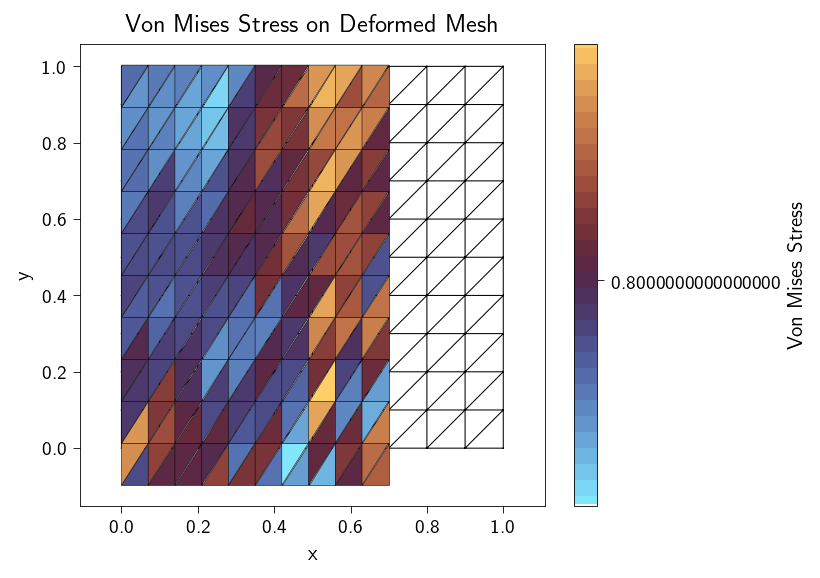

In [22]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

plot_displacement_and_stress(ax, u_solution, mesh, stress_vm)